<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/TRM_Sirve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [2]:
import tensorflow as tf
print (tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import torch
from torch.autograd import Variable
import torch

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print (tf.keras.__version__)
print (pd.__version__)

2.3.0-tf
1.0.3


In [5]:
df = pd.read_csv('Datos_TRM.csv')
df.tail(5)

,Index,Data Time,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_EfcRate,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
1275,1276,24/04/2020,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.05,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
1276,1277,27/04/2020,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.04,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
1277,1278,28/04/2020,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.04,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
1278,1279,29/04/2020,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.04,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
1279,1280,30/04/2020,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.04,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


In [0]:
TRAIN_SPLIT =1198

In [0]:
tf.random.set_seed(13)

**#tf.keras.utils.normalize**


In [8]:
df.index = df['Data Time']
df.columns

Index(['Index', 'Data Time', 'TRM', 'TRM_logn', 'IBR', 'YTES1Y_COP',
       'YTES5Y_COP', 'YTES10Y_COP', 'YTES1Y_UVR', 'YTES5Y_UVR', 'YTES10Y_UVR',
       'FF_EfcRate', 'FF_UB', 'WTI_USD', 'GOLD_USD', 'VAR_TRM', 'VAR_LNTRM',
       'MM_5', 'MM_20'],
      dtype='object')

In [0]:
#y_data = df_target.values[:-shift_steps]
#print(type(y_data))
#print("Shape:", y_data.shape)
#df_target=df[Target].shift(-shift_steps)

In [9]:
Target='TRM'
target_name=['TRM']
shift_steps = 82  # dias de 202
df_target=df[target_name].shift(-shift_steps)
df_target.tail(84)

,TRM
Data Time,
30/12/2019,4046.04
31/12/2019,3983.29
2/01/2020,NaN
3/01/2020,NaN
7/01/2020,NaN
...,...
24/04/2020,NaN
27/04/2020,NaN
28/04/2020,NaN


In [0]:
features_considered=['TRM_logn', 'IBR', 'WTI_USD', 'GOLD_USD', 'VAR_TRM', 'VAR_LNTRM', 'MM_5',
       'MM_20']

In [0]:
features = df[features_considered]
features.index = df['Data Time']
features.tail()
x_data = features.values[0:-shift_steps]


In [12]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1198, 8)


In [13]:
y_data = df_target.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1198, 1)


In [14]:
num_data = len(x_data)
num_data

1198

In [0]:
train_split = 0.9

In [16]:
num_train = int(train_split * num_data)
num_train

1078

In [17]:
num_test = num_data - num_train
num_test

120

In [18]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1198

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1198

In [20]:
num_x_signals = x_data.shape[1]
num_x_signals

8

In [21]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

# Create the Scaler object scaler = StandardScaler()
x_scaled = StandardScaler()

x_train_scaled = x_scaled.fit_transform(x_train)
x_test_scaled=x_scaled.transform(x_test)

In [23]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: -3.850902776625826
Max: 4.331086940634542


In [0]:
#y_scaler = MinMaxScaler()
#y_train_scaled = y_scaler.fit_transform(y_train)
#y_test_scaled = y_scaler.transform(y_test)
y_train_scaled = y_train
y_test_scaled =y_test


In [25]:
#generando datos
print(x_train_scaled.shape)
print(y_train.shape)

(1078, 8)
(1078, 1)


In [0]:
#cuando hay muchos datos se utiliza esta funcion para hacelos por batch
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 256

In [28]:
sequence_length = 20*12
sequence_length

240

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [31]:
print(x_batch.shape)
print(y_batch.shape)

(256, 240, 8)
(256, 240, 1)


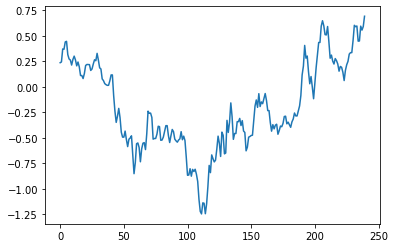

In [32]:
#una de las señales
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

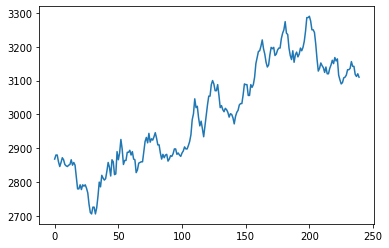

In [33]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
#conjunto de validación
validation_data = (np.expand_dims(x_test_scaled, axis=0),np.expand_dims(y_test_scaled, axis=0))

In [0]:
#crear la red
model = Sequential()
#Gated Recurrent Unit con 512 salidas por cada eime-step in la sequencia
model.add(GRU(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
#función de activación
model.add(Dense(num_y_signals, activation='relu'))#sigmoid


In [0]:
#if False:
#    from tensorflow.python.keras.initializers import RandomUniform
#
    # Maybe use lower init-ranges.
#    init = RandomUniform(minval=-0.05, maxval=0.05)#

#    model.add(Dense(num_y_signals,
#                     activation='linear',
#                    kernel_initializer=init))

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [38]:
#Modelo compilador
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         801792    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 802,305
Trainable params: 802,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
#PARA SALVAR ALGUNOS PUNTOS DURANTE EL APRENDIZAJE CALLBACKS
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
# CALLBACK PARA PARAR LA OPTIMIZACIÓNCUANDO DESEMPEÑO EMPEORE EN EL CONJUNTO DE VALIDACION
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
#REPORTE DE LA CORRIDA
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
#PARA EL APRENDIZAJE SI NO MEJORA LA TASA DE APRENDIZAJE DESPUES DE CIRTAS EPOCHS
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                        patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [45]:
#NEURAL NETWORK
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 8756844.0000
Epoch 00001: val_loss improved from inf to 13235408.00000, saving model to 23_checkpoint.keras
100/100 [==============================] - 719s 7s/step - loss: 8756844.0000 - val_loss: 13235408.0000 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 8437776.0000
Epoch 00002: val_loss improved from 13235408.00000 to 12855745.00000, saving model to 23_checkpoint.keras
100/100 [==============================] - 712s 7s/step - loss: 8437776.0000 - val_loss: 12855745.0000 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 8146604.0000
Epoch 00003: val_loss improved from 12855745.00000 to 12492166.00000, saving model to 23_checkpoint.keras
100/100 [==============================] - 736s 7s/step - loss: 8146604.0000 - val_loss: 12492166.0000 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 7860167.5000
Epoch 00004: 

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [55]:
#TEST SET
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
print("loss (test-set):",result)

1/1 [==============================] - 0s 2ms/step - loss: 7120754.5000
loss (test-set): 7120754.5


In [0]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [0]:
#funcion para generar predicciones
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    #y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_name)):
        # Get the output-signal predicted by the model.
        #signal_pred = y_pred_rescaled[:, signal]
        signal_pred = y_pred[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_name[signal])
        plt.legend()
        plt.show()

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    #y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_name)):
        # Get the output-signal predicted by the model.
        #signal_pred = y_pred_rescaled[:, signal]
        signal_pred = y_train_scaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_name[signal])
        plt.legend()
        plt.show()

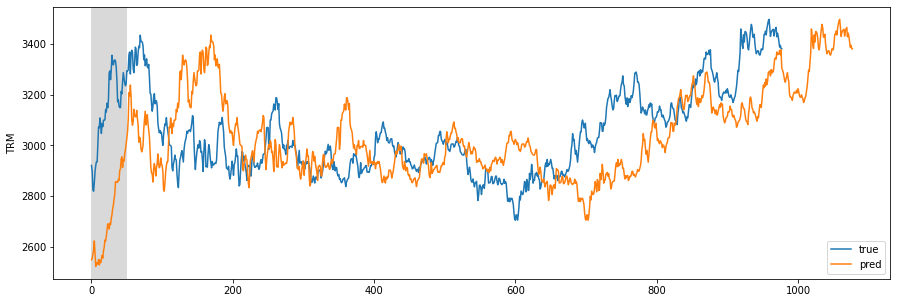

In [83]:
plot_comparison(start_idx=100, length=1200, train=True)

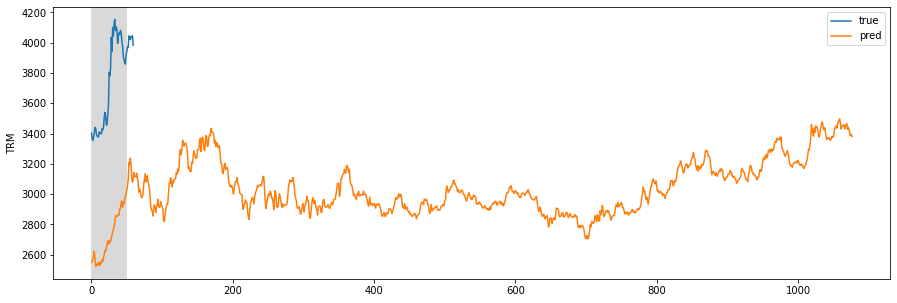

In [82]:
plot_comparison(start_idx=60, length=100, train=False)

In [0]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
dataset

In [0]:
past_history = 1120
future_target = 80
STEP = 5

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

In [0]:
#función para escoger parte de los datos
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train_single, window_size, batch_size, shuffle_buffer_size)
print(x_train_single.shape)

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)